# Projeto Marinha do Brasil

## Laboratório de Processamento de Sinais - UFRJ

### Autor: Vinícius dos Santos Mello <viniciusdsmello@poli.ufrj.br>

In [5]:
import os
import sys
import pickle
import numpy as np
import time

from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K

import sklearn.metrics
from sklearn.externals import joblib
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt

from Functions import TrainParameters as trnparams
from Functions import TrainFunctions
from Functions.StackedAutoEncoders import StackedAutoEncoders
from Functions import FunctionsDataVisualization

import multiprocessing

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'StackedAutoEncoder'

# Enviroment variables
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

# paths to export results
base_results_path = '%s/%s'%(results_path,analysis_name)
pict_results_path = '%s/pictures_files'%(base_results_path)
files_results_path = '%s/output_files'%(base_results_path)

# For multiprocessing purpose
num_processes = multiprocessing.cpu_count()

# Read data
m_time = time.time()

# Database caracteristics
database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag = False
development_events = 400

# Check if LofarData has created...
if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))


    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

    # Process data
    # unbalanced data to balanced data with random data creation of small classes

    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)

    balanced_data = {}
    balanced_trgt = {}

    from Functions import DataHandler as dh
    m_datahandler = dh.DataHandlerFunctions()

    for iclass, class_label in enumerate(class_labels):
        if development_flag:
            class_events = all_data[all_trgt==iclass,:]
            if len(balanced_data) == 0:
                balanced_data = class_events[0:development_events,:]
                balanced_trgt = (iclass)*np.ones(development_events)
            else:
                balanced_data = np.append(balanced_data,
                                          class_events[0:development_events,:],
                                          axis=0)
                balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
        else:
            if len(balanced_data) == 0:
                class_events = all_data[all_trgt==iclass,:]
                balanced_data = m_datahandler.CreateEventsForClass(
                    class_events,qtd_events_biggest_class-(len(class_events)))
                balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
            else:
                class_events = all_data[all_trgt==iclass,:]
                created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
                                                                     qtd_events_biggest_class-
                                                                     (len(class_events))))
                balanced_data = np.append(balanced_data,created_events,axis=0)
                balanced_trgt = np.append(balanced_trgt,
                                          (iclass)*np.ones(created_events.shape[0]),axis=0)

    all_data = balanced_data
    all_trgt = balanced_trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

Time to import all libraries: 2.09808349609e-05 seconds
Time to read data file: 0.935601949692 seconds
Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)


# Carregar parâmetros de treinamento

In [10]:
# Load train parameters
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if os.path.exists(trn_params_folder):
    os.remove(trn_params_folder)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.SAENoveltyDetectionTrnParams(n_inits=1,
                                                       hidden_activation='tanh', # others tanh, relu, sigmoid, linear 
                                                       output_activation='linear',
                                                       n_epochs=500,
                                                       patience=30,
                                                       batch_size=128,
                                                       verbose=True,
                                                       optmizerAlgorithm='Adam',
                                                       metrics=['accuracy'], #mean_squared_error
                                                       loss='mean_squared_error') #kullback_leibler_divergence
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.SAENoveltyDetectionTrnParams()
    trn_params.load(trn_params_folder)
    
# Choose how many fold to be used in Cross Validation
n_folds = 10
CVO = trnparams.NoveltyDetectionFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag, verbose=True)
print '\n'+trn_params.get_params_str()

Reading from /home/vinicius.mello/Workspace/SonarAnalysis/Results/NoveltyDetection/10_folds_cross_validation.jbl

1_inits_mapstd_norm_500_epochs_128_batch_size_tanh_hidden_activation_linear_output_activation_accuracy_metric_mean_squared_error_loss


# Treinamento do Stacked Auto Encoder

In [8]:
%time
SAE = {}
trn_data = {}
trn_trgt = {}
for inovelty, novelty_class in enumerate(np.unique(trgt)):
    trn_data[inovelty] = all_data[all_trgt!=novelty_class]
    trn_trgt[inovelty] = all_trgt[all_trgt!=novelty_class]
    trn_trgt[inovelty][trn_trgt[inovelty]>novelty_class] = trn_trgt[inovelty][trn_trgt[inovelty]>novelty_class]-1
    
    # Initialize an SAE object for all novelties
    SAE[inovelty] = StackedAutoEncoders(params           = trn_params,
                                        development_flag = development_flag,
                                        n_folds          = n_folds,
                                        save_path        = results_path,
                                        CVO              = CVO,
                                        noveltyDetection = True,
                                        inovelty         = inovelty)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [23]:
hidden_neurons = range(400,0,-50) + [2]

In [24]:
hidden_neurons[layer-1]

400

In [11]:
##### Train Process #####
inovelty = 1
novelty_train = [inovelty]
print 'Novelty to Train: %i'%inovelty

# Choose layer to be trained
layer = 1

n_folds = len(CVO[inovelty])

hidden_neurons = range(400,0,-50) + [2]
print hidden_neurons

regularizer = ""
regularizer_param = 0.5

# Functions defined to be used by multiprocessing.Pool()
def trainNeuron(ineuron):
    for ifold in range(n_folds):
        SAE[inovelty].trainLayer(data = trn_data[inovelty],
                                 trgt = trn_trgt[inovelty],
                                 ifold = ifold,
                                 hidden_neurons = hidden_neurons + [ineuron],
                                 layer = layer,
                                 regularizer = regularizer,
                                 regularizer_param = regularizer_param)

def trainFold(ifold):
    return  SAE[inovelty].trainLayer(data = trn_data[inovelty],
                                     trgt = trn_trgt[inovelty],
                                     ifold = ifold,
                                     hidden_neurons = hidden_neurons,
                                     layer = layer,
                                     regularizer = regularizer,
                                     regularizer_param = regularizer_param)

start_time = time.time()

if K.backend() == 'theano':
    # Start Parallel processing
    p = multiprocessing.Pool(processes=num_processes)

    ####################### SAE LAYERS ############################
    # It is necessary to choose the layer to be trained

    # To train on multiple cores sweeping the number of folds
    folds = range(len(CVO[inovelty]))
    results = p.map(trainFold, folds)

    # To train multiple topologies sweeping the number of neurons
    # neurons_mat = range(0,400,50) (start,final,step)
    # results = p.map(trainNeuron, neurons_mat)

    p.close()
    p.join()
else: 
    for ifold in range(len(CVO[inovelty])):
        result = trainFold(ifold)

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

Novelty to Train: 1
[400, 350, 300, 250, 200, 150, 100, 50, 2]
[+] Using Adam as optmizer algorithm
File /home/vinicius.mello/Workspace/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/RawData_1_novelty_10_folds_1_inits_mapstd_norm_500_epochs_128_batch_size_tanh_hidden_activation_linear_output_activation_accuracy_metric_mean_squared_error_loss_400x400_neurons_fold_0_model.h5 exists
[+] Using Adam as optmizer algorithm
File /home/vinicius.mello/Workspace/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/RawData_1_novelty_10_folds_1_inits_mapstd_norm_500_epochs_128_batch_size_tanh_hidden_activation_linear_output_activation_accuracy_metric_mean_squared_error_loss_400x400_neurons_fold_1_model.h5 exists
[+] Using Adam as optmizer algorithm
File /home/vinicius.mello/Workspace/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/RawData_1_novelty_10_folds_1_inits_mapstd_norm_500_epochs_128_batch_size_tanh_hidden_activation_linear_output_activation_accuracy_metric_mean_sq

# Análise de Correlação

Novelty class: 1 - Topology: 400x400 - fold 0
[+] Using Adam as optmizer algorithm
File /home/vinicius.mello/Workspace/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/RawData_1_novelty_10_folds_1_inits_mapstd_norm_500_epochs_128_batch_size_tanh_hidden_activation_linear_output_activation_accuracy_metric_mean_squared_error_loss_400x400_neurons_fold_0_model.h5 exists
Novelty class: 1 - Topology: 400x400 - fold 1
[+] Using Adam as optmizer algorithm
File /home/vinicius.mello/Workspace/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/RawData_1_novelty_10_folds_1_inits_mapstd_norm_500_epochs_128_batch_size_tanh_hidden_activation_linear_output_activation_accuracy_metric_mean_squared_error_loss_400x400_neurons_fold_1_model.h5 exists
Novelty class: 1 - Topology: 400x400 - fold 2
[+] Using Adam as optmizer algorithm
File /home/vinicius.mello/Workspace/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/RawData_1_novelty_10_folds_1_inits_mapstd_norm_500_epochs_128_batch_s

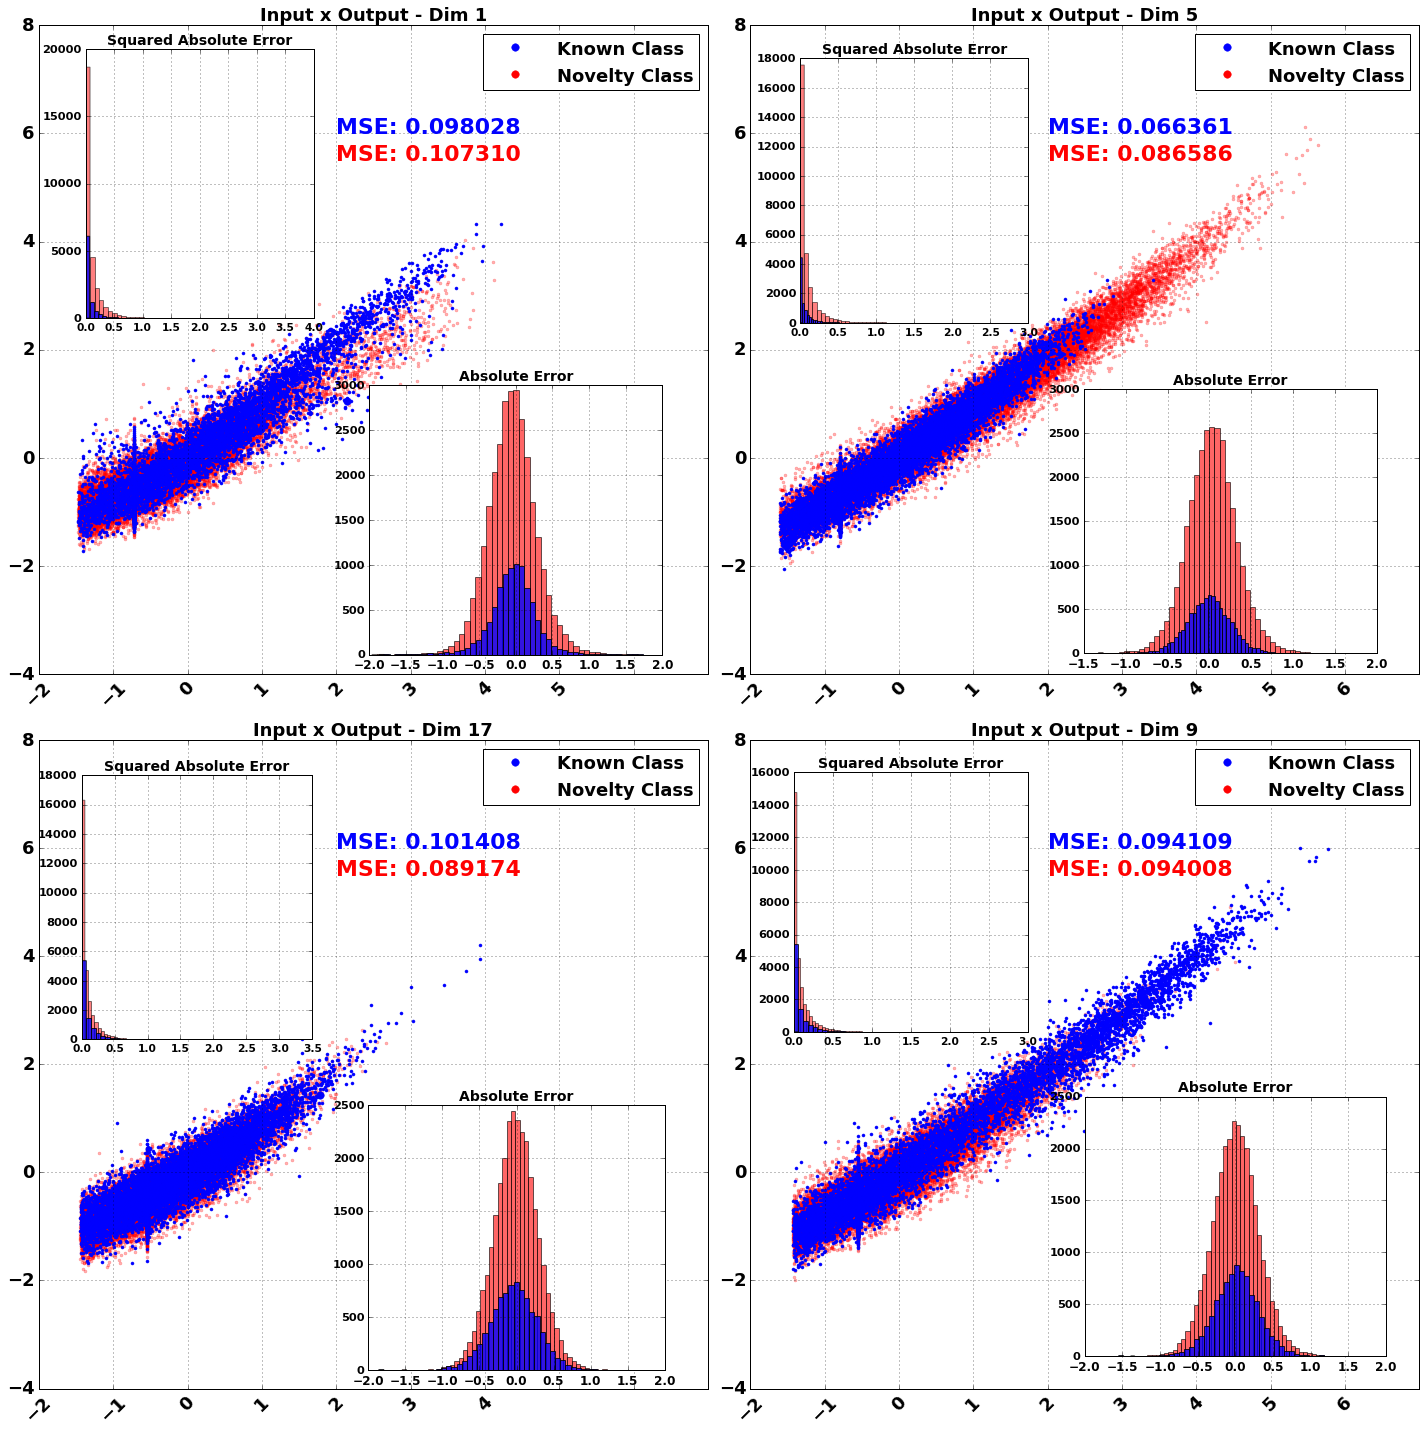

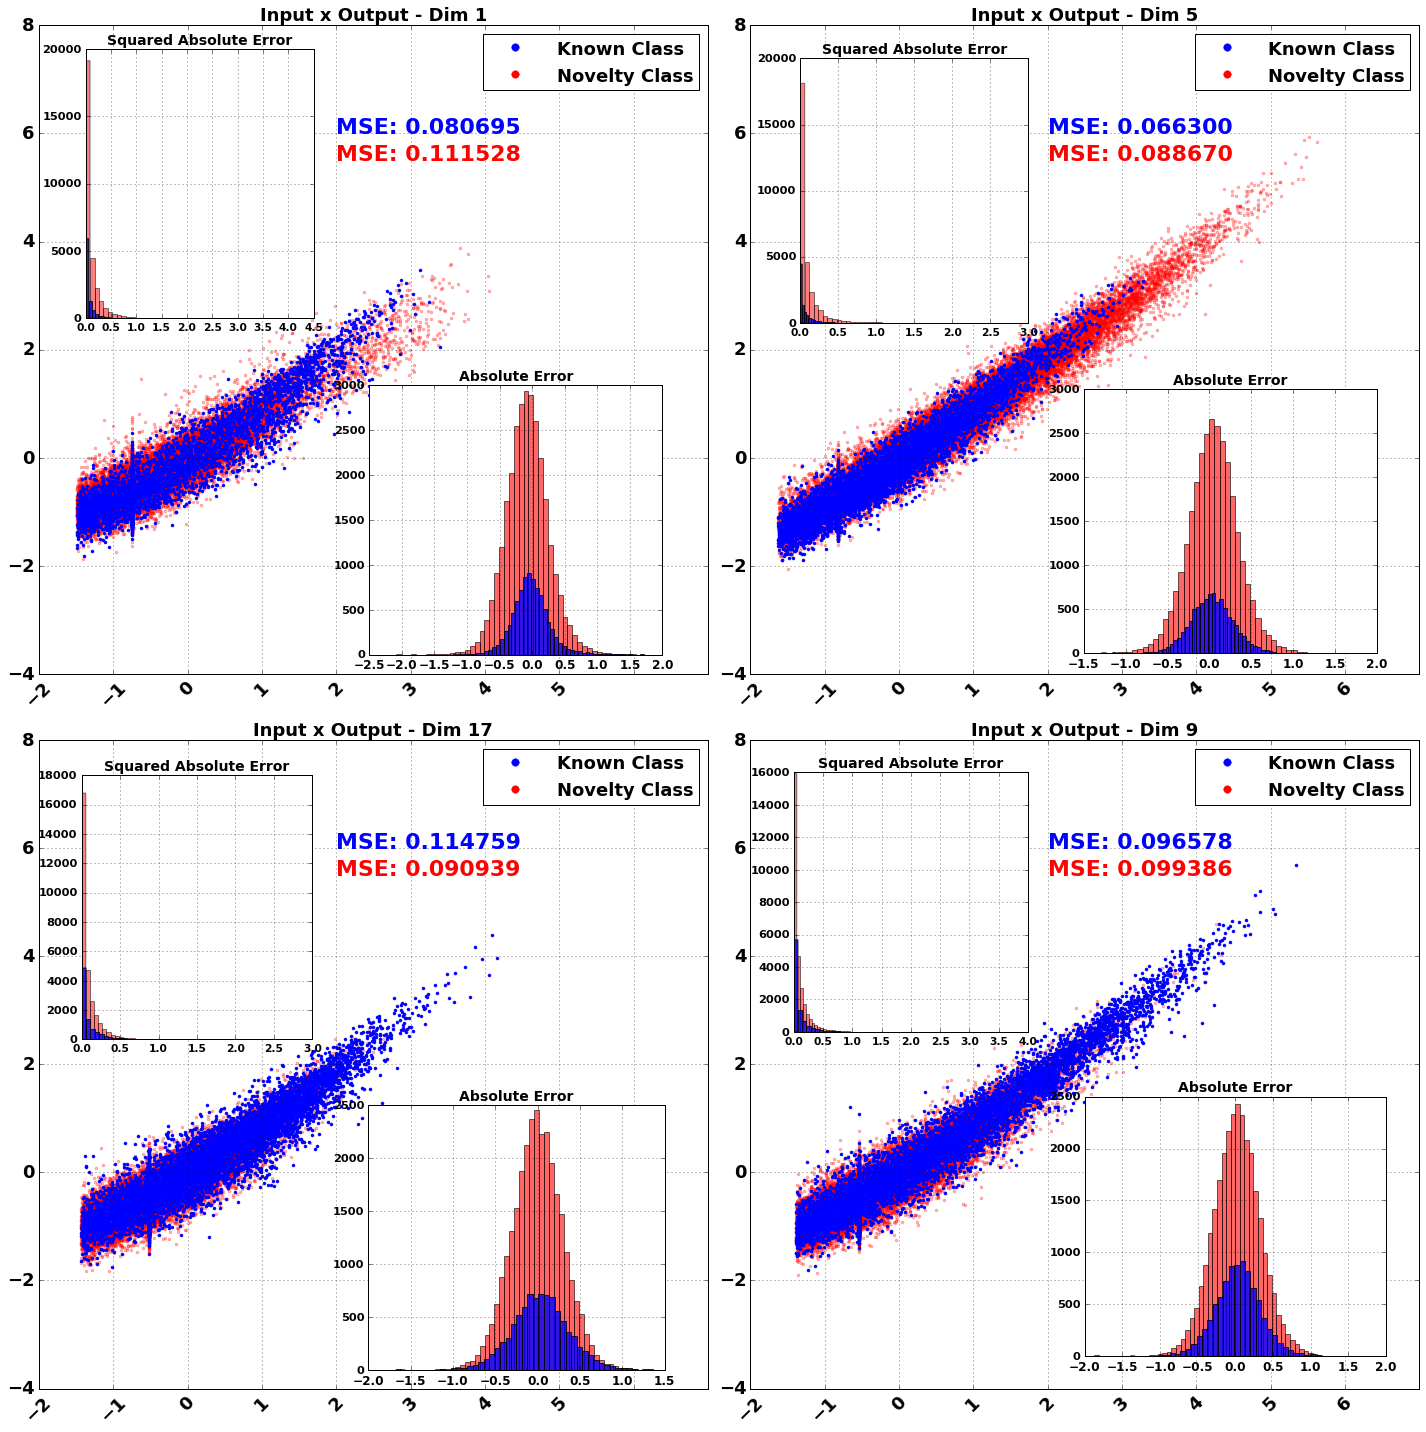

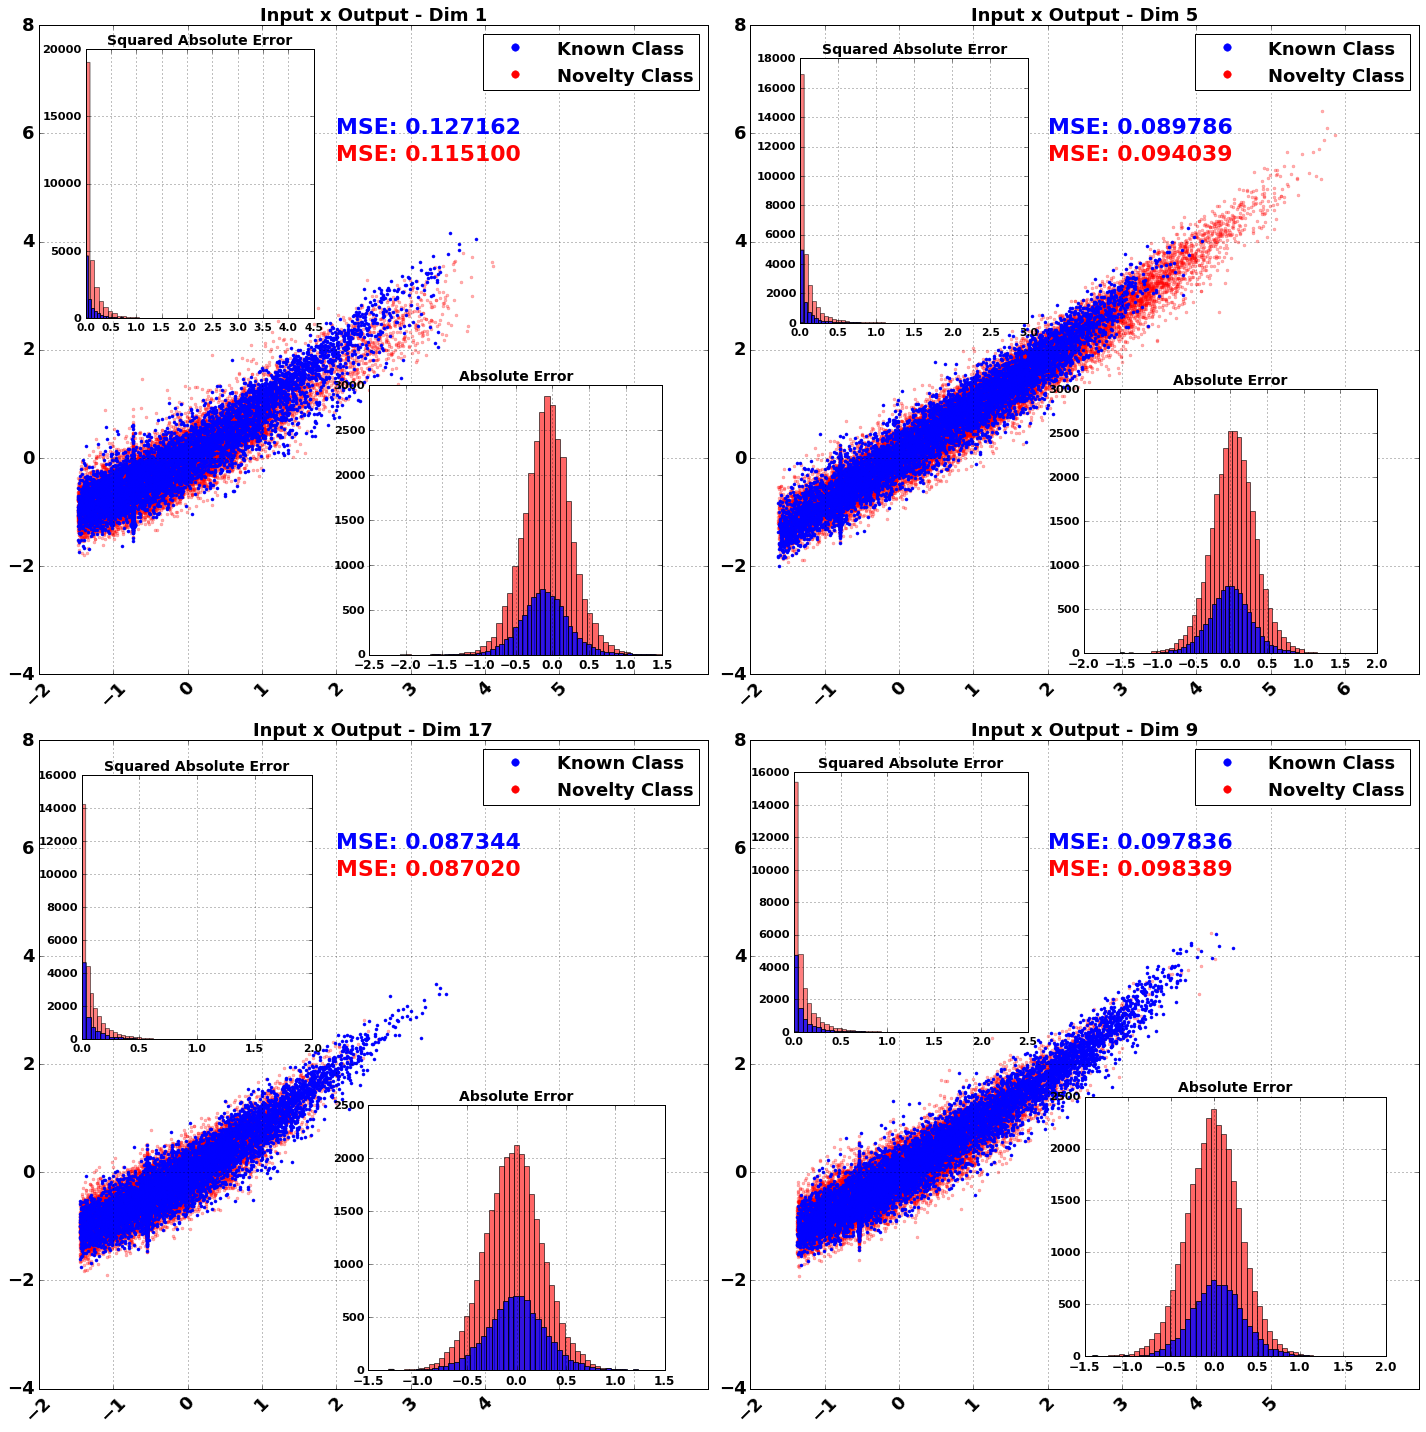

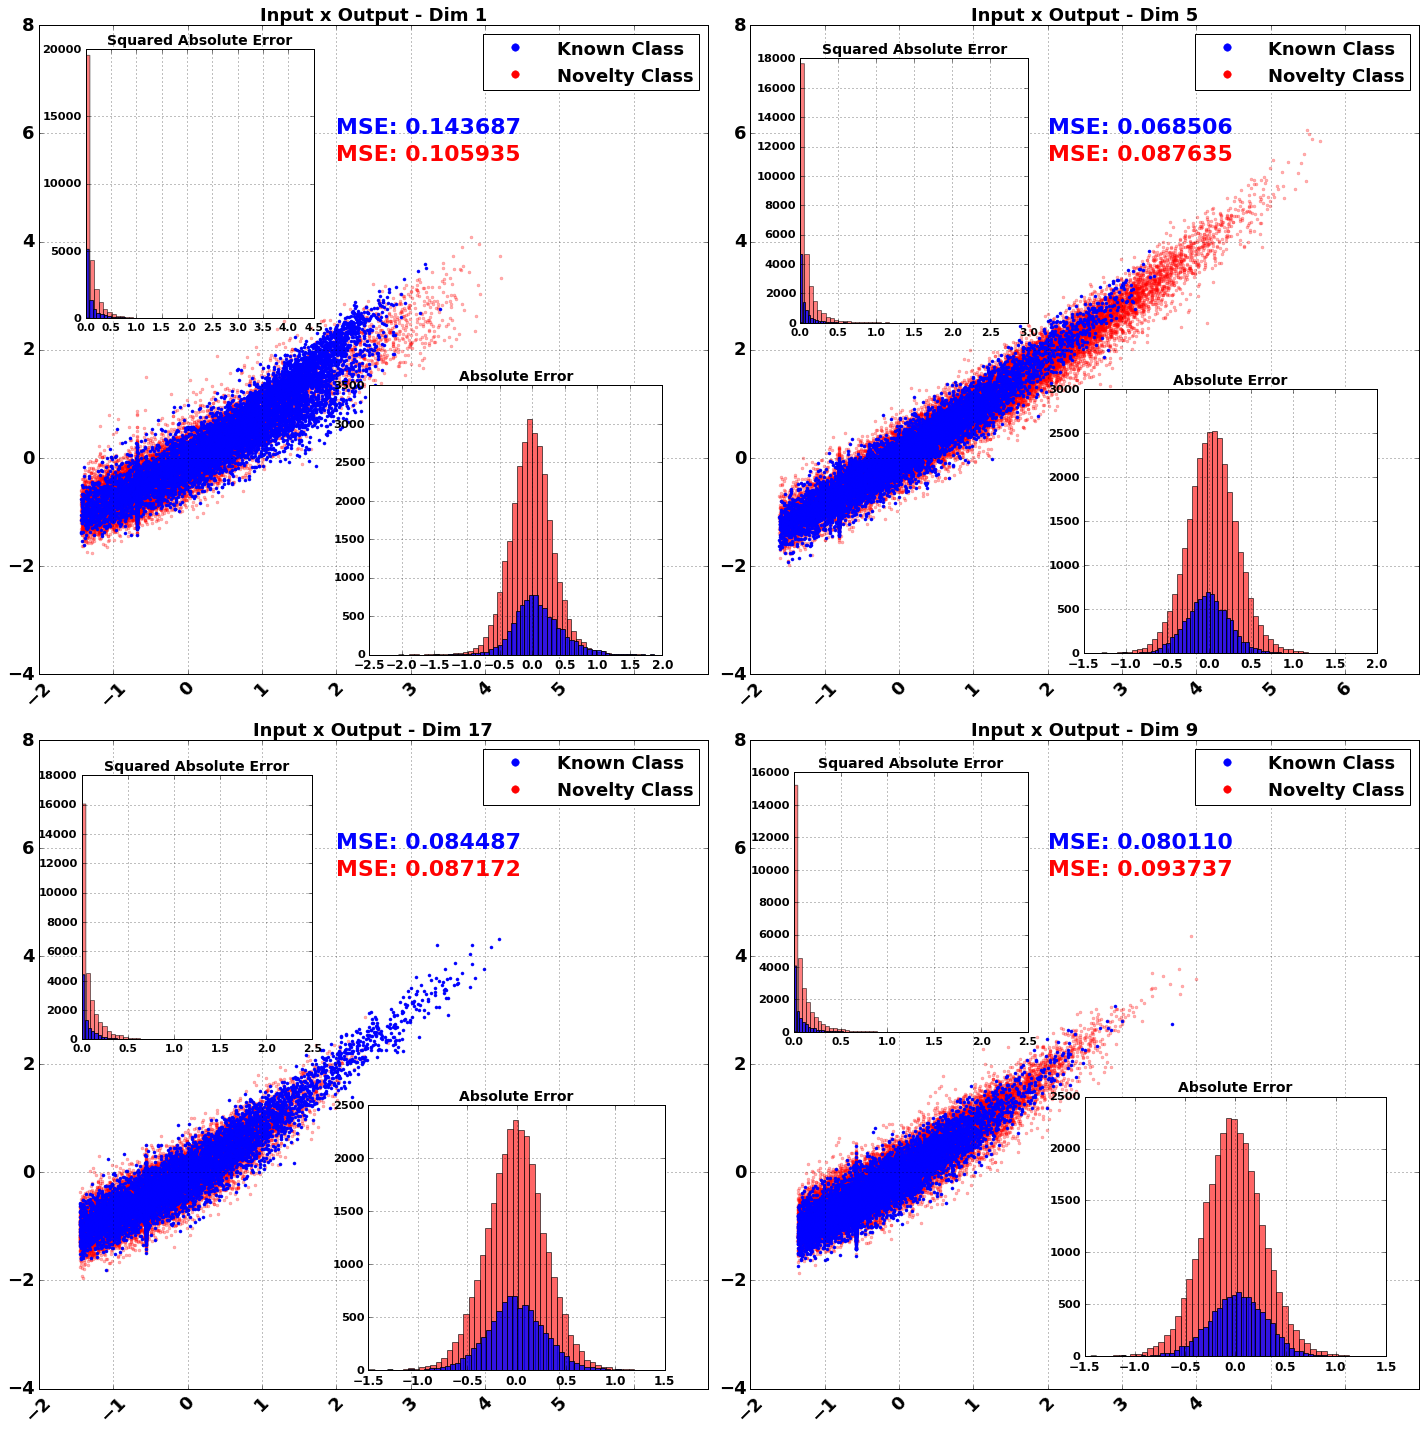

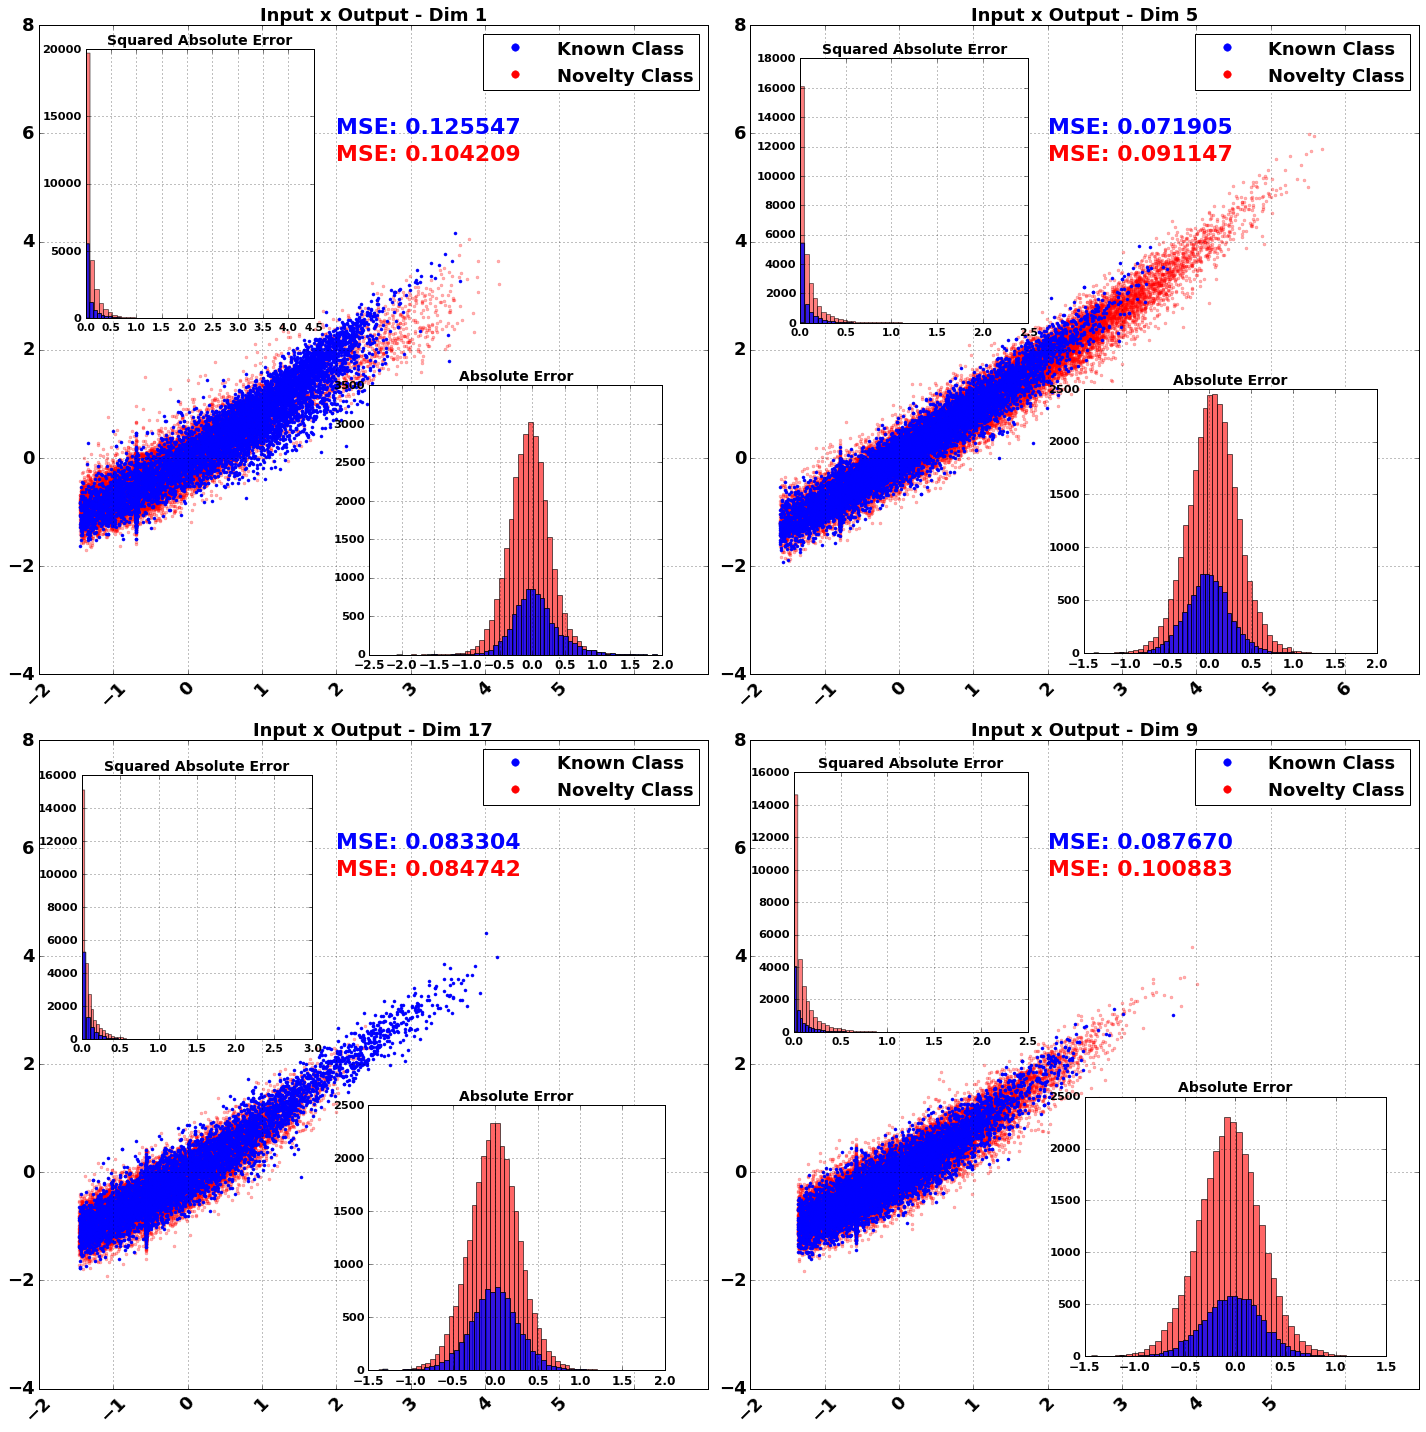

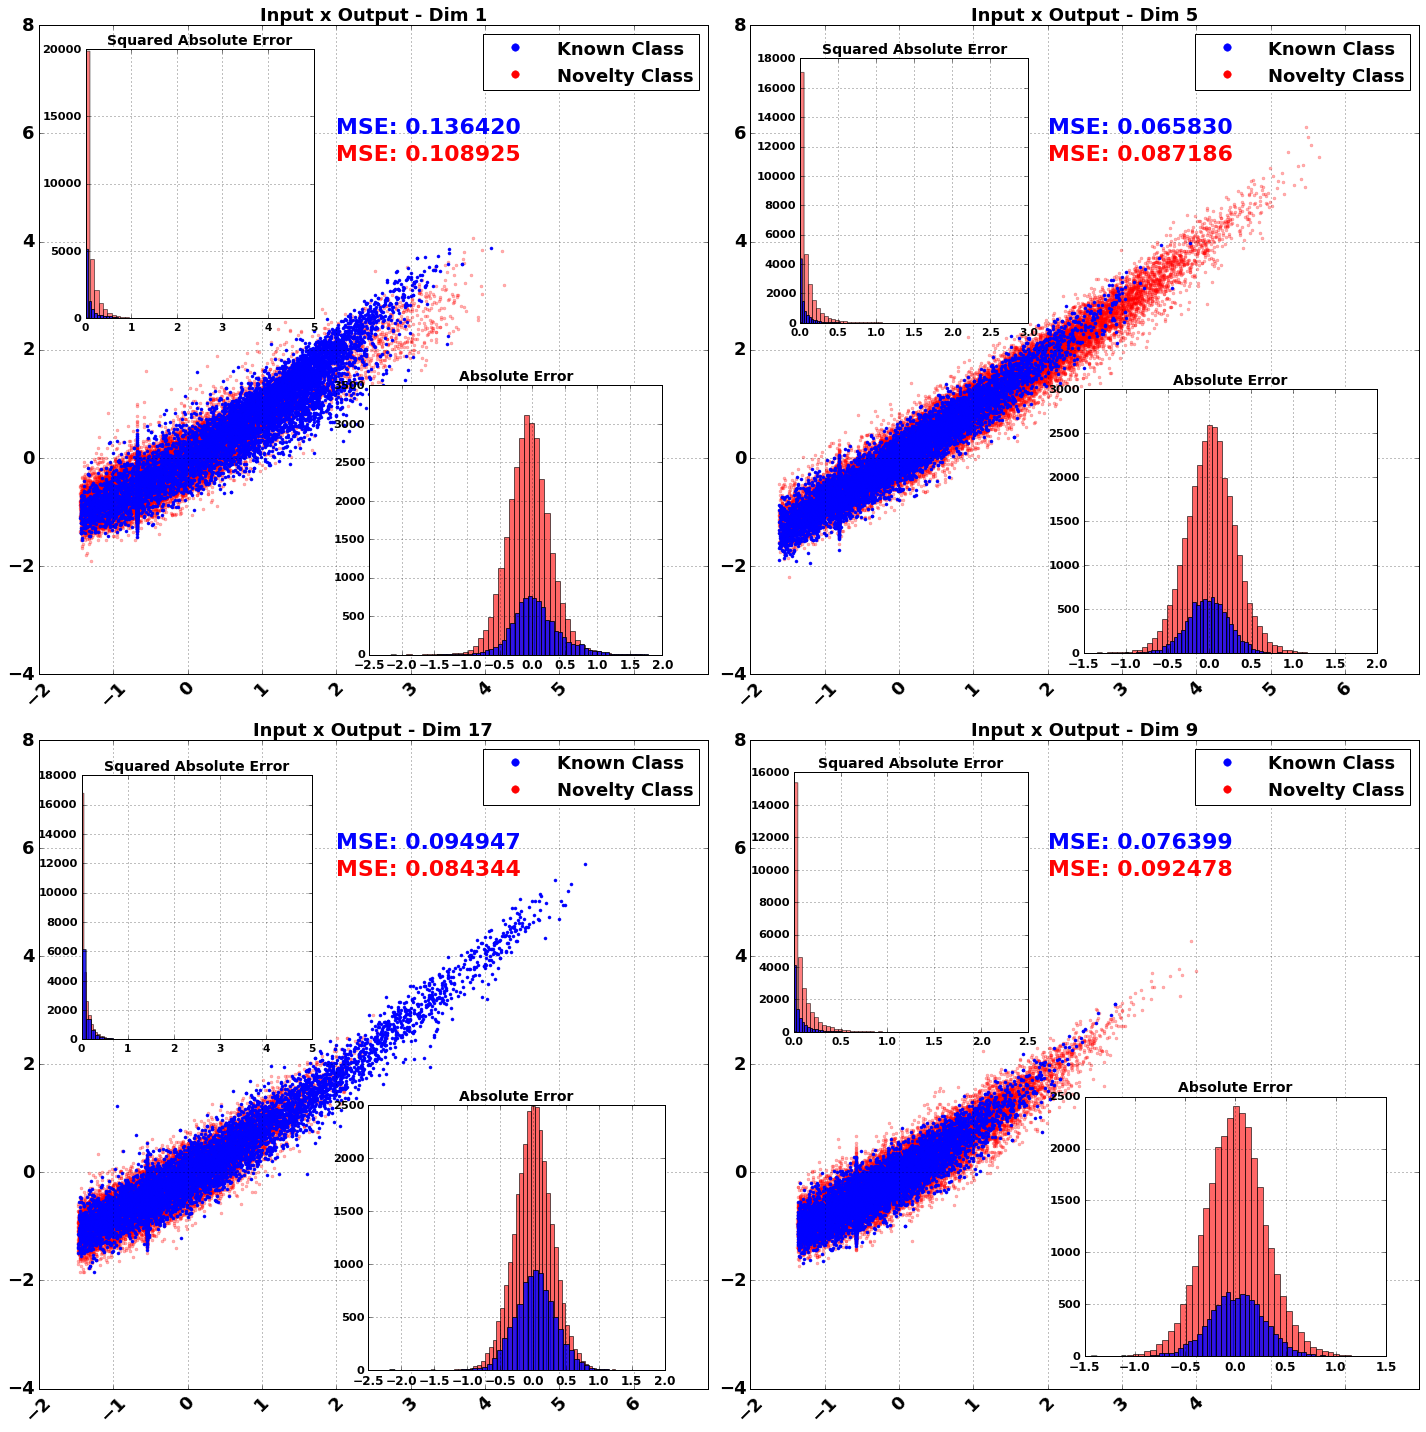

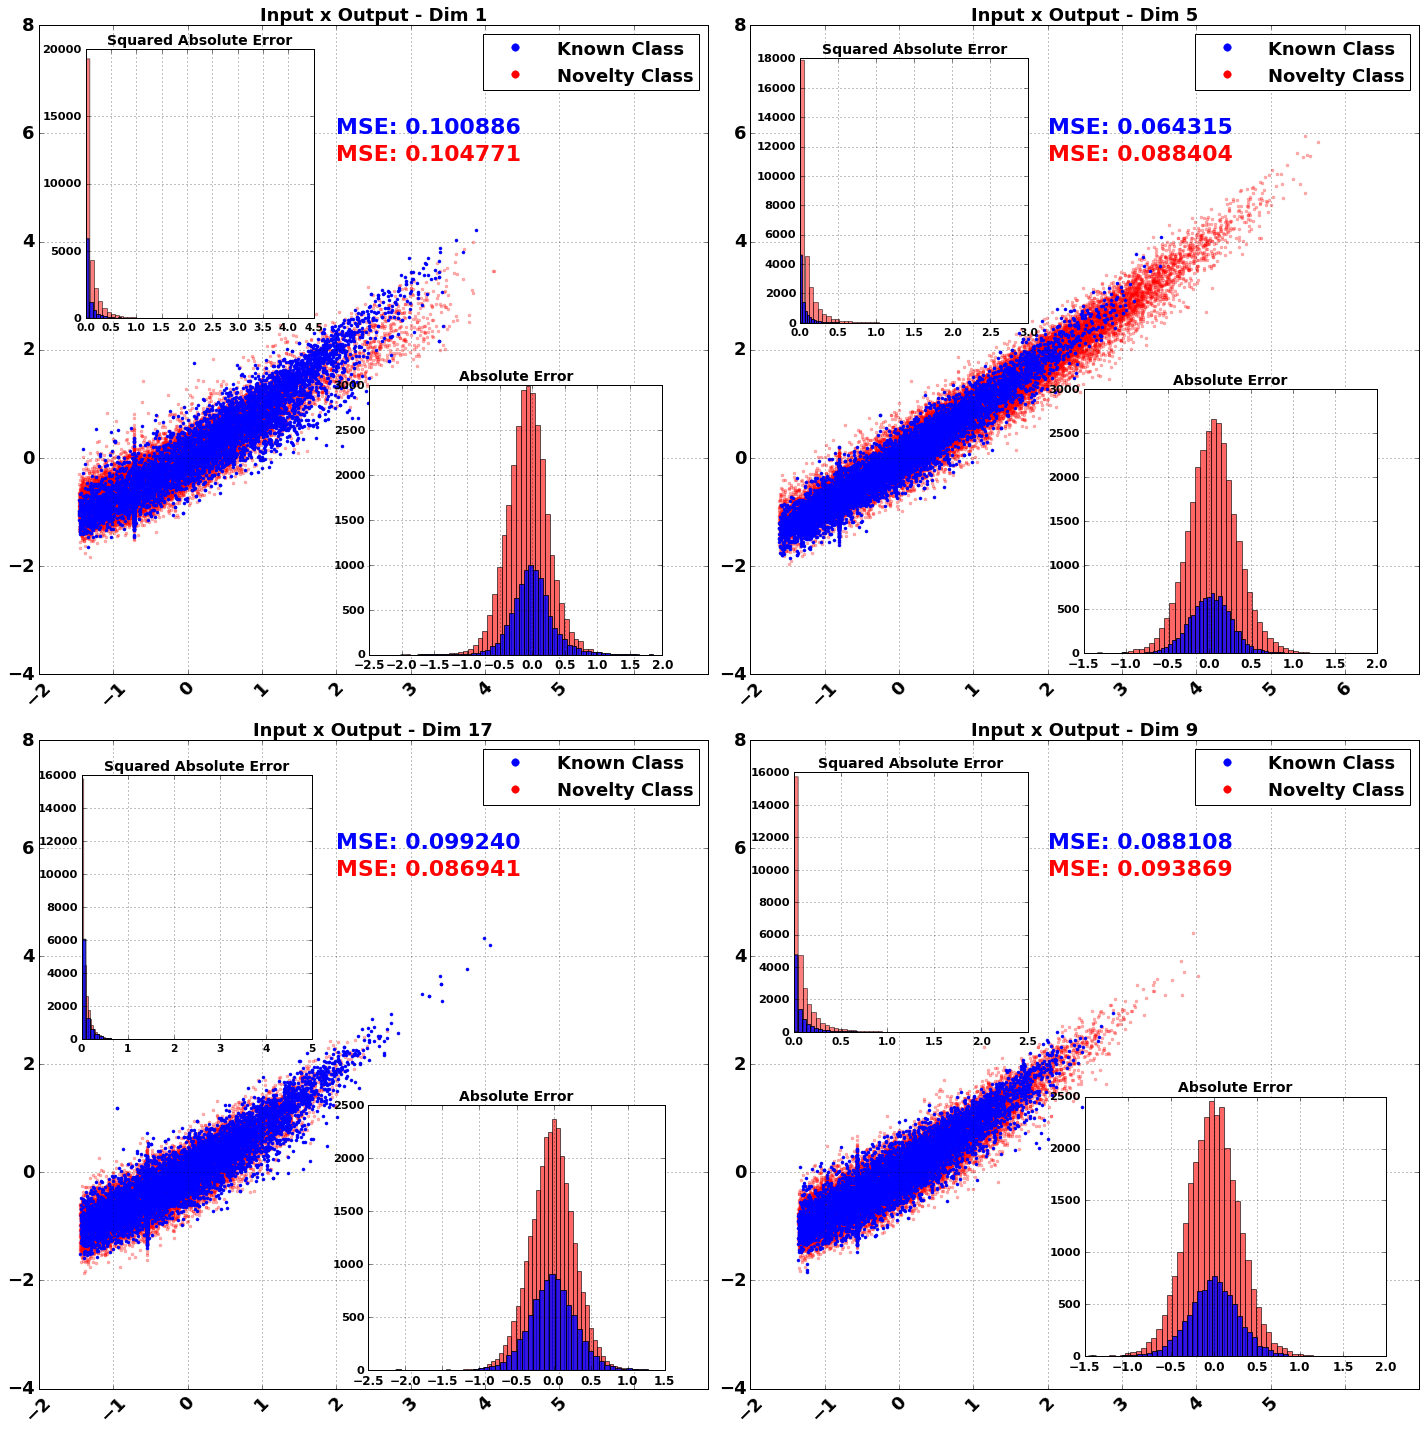

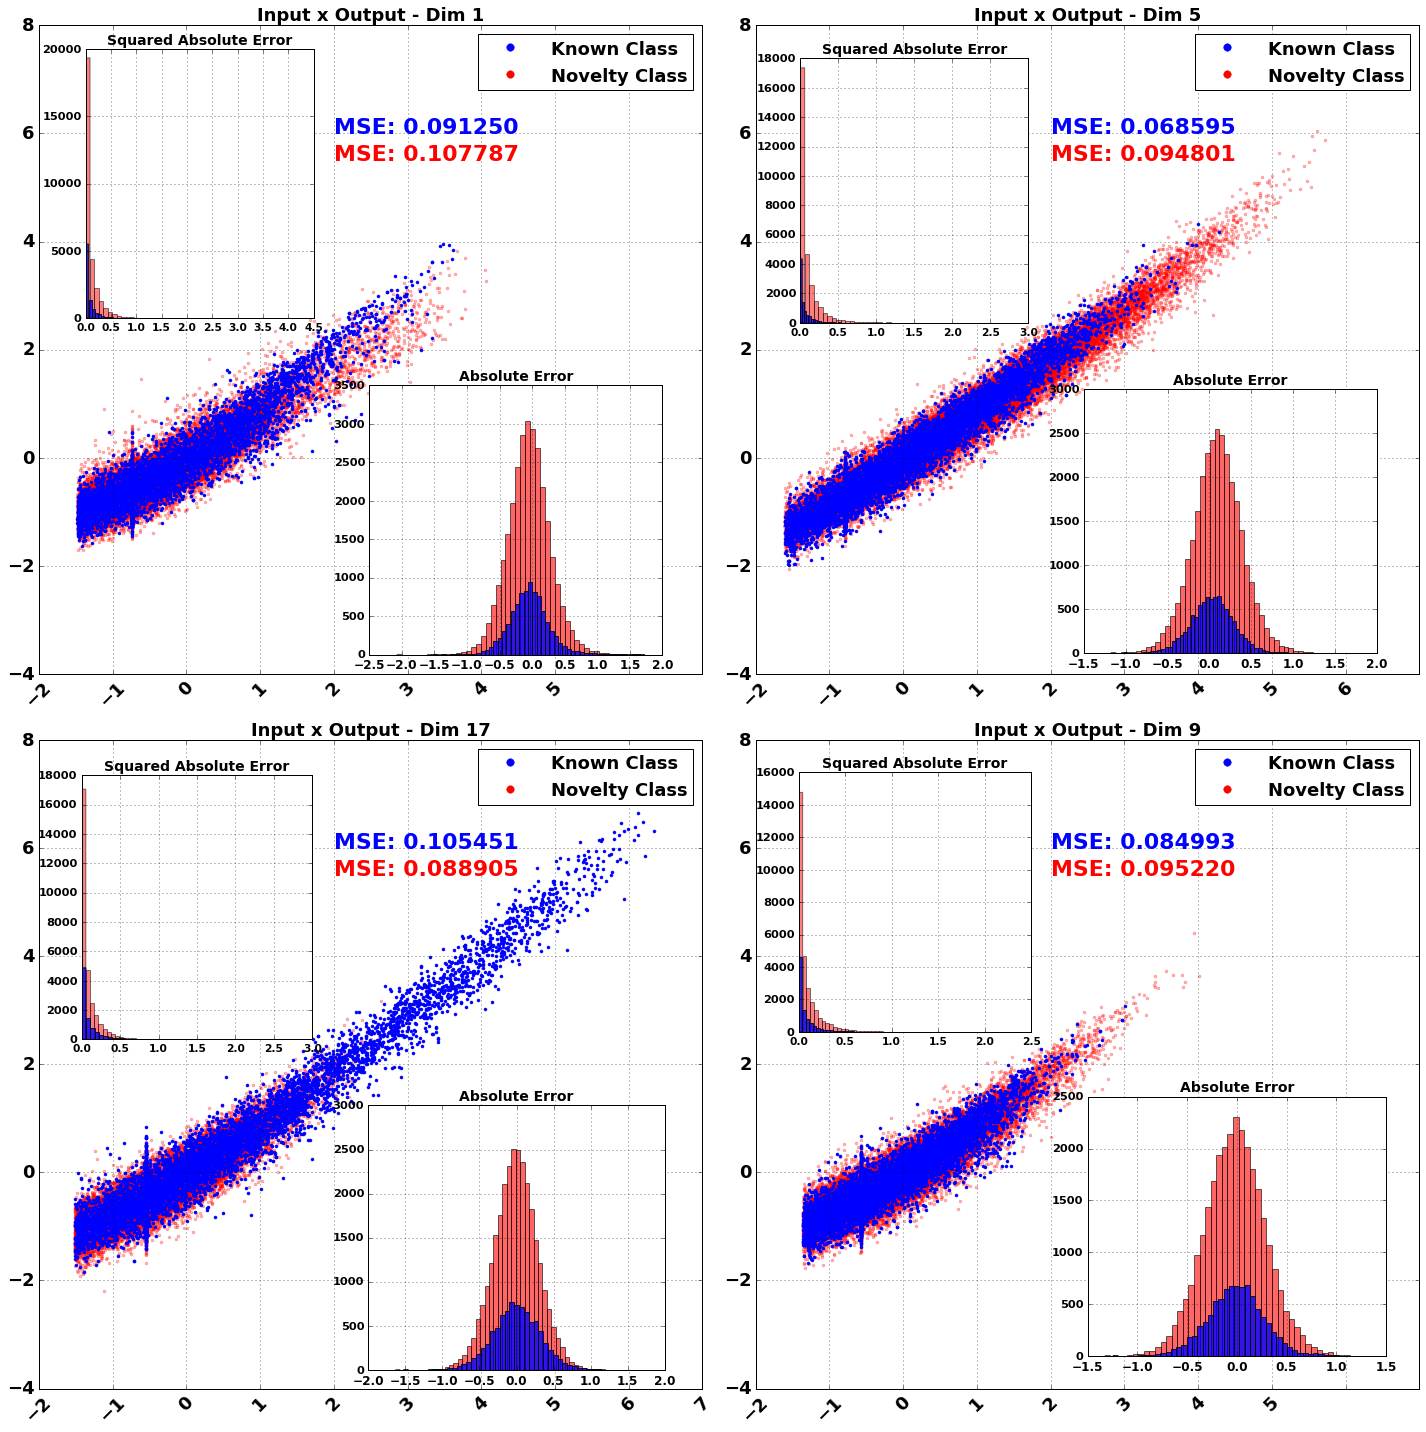

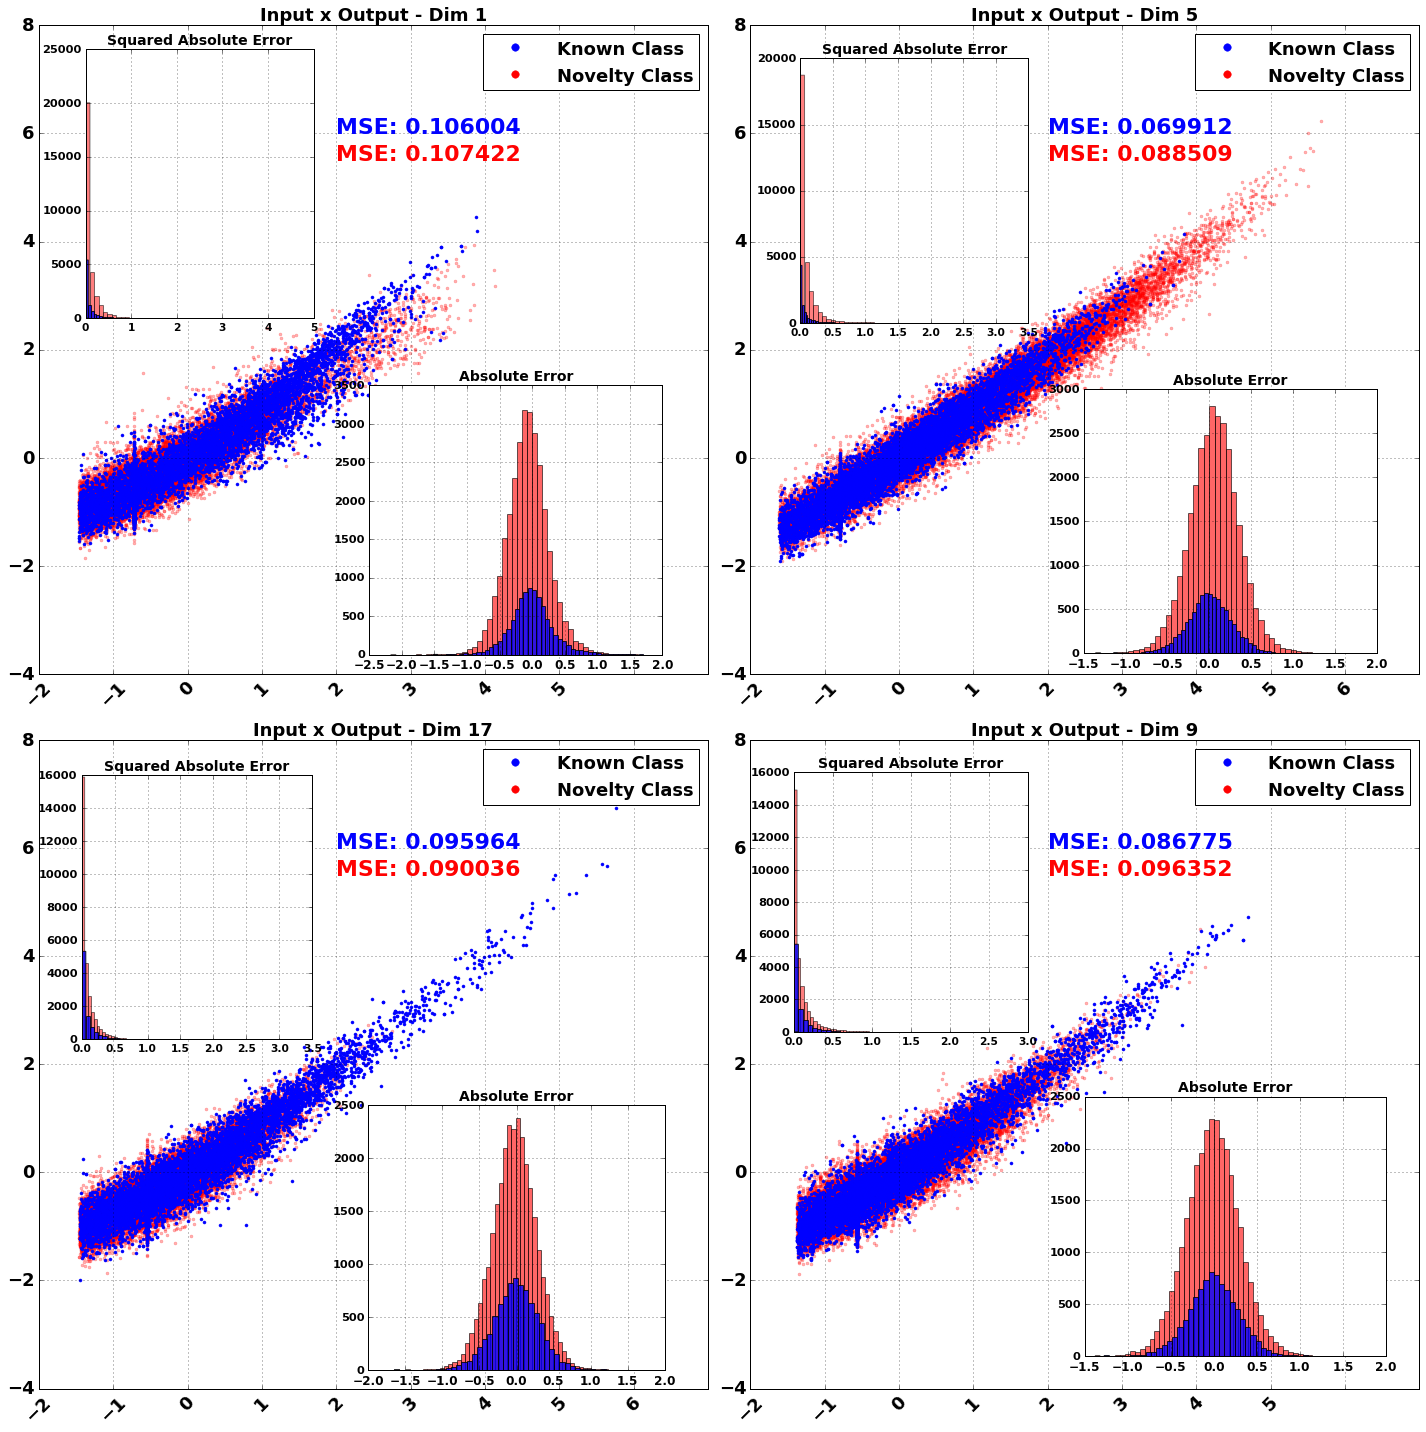

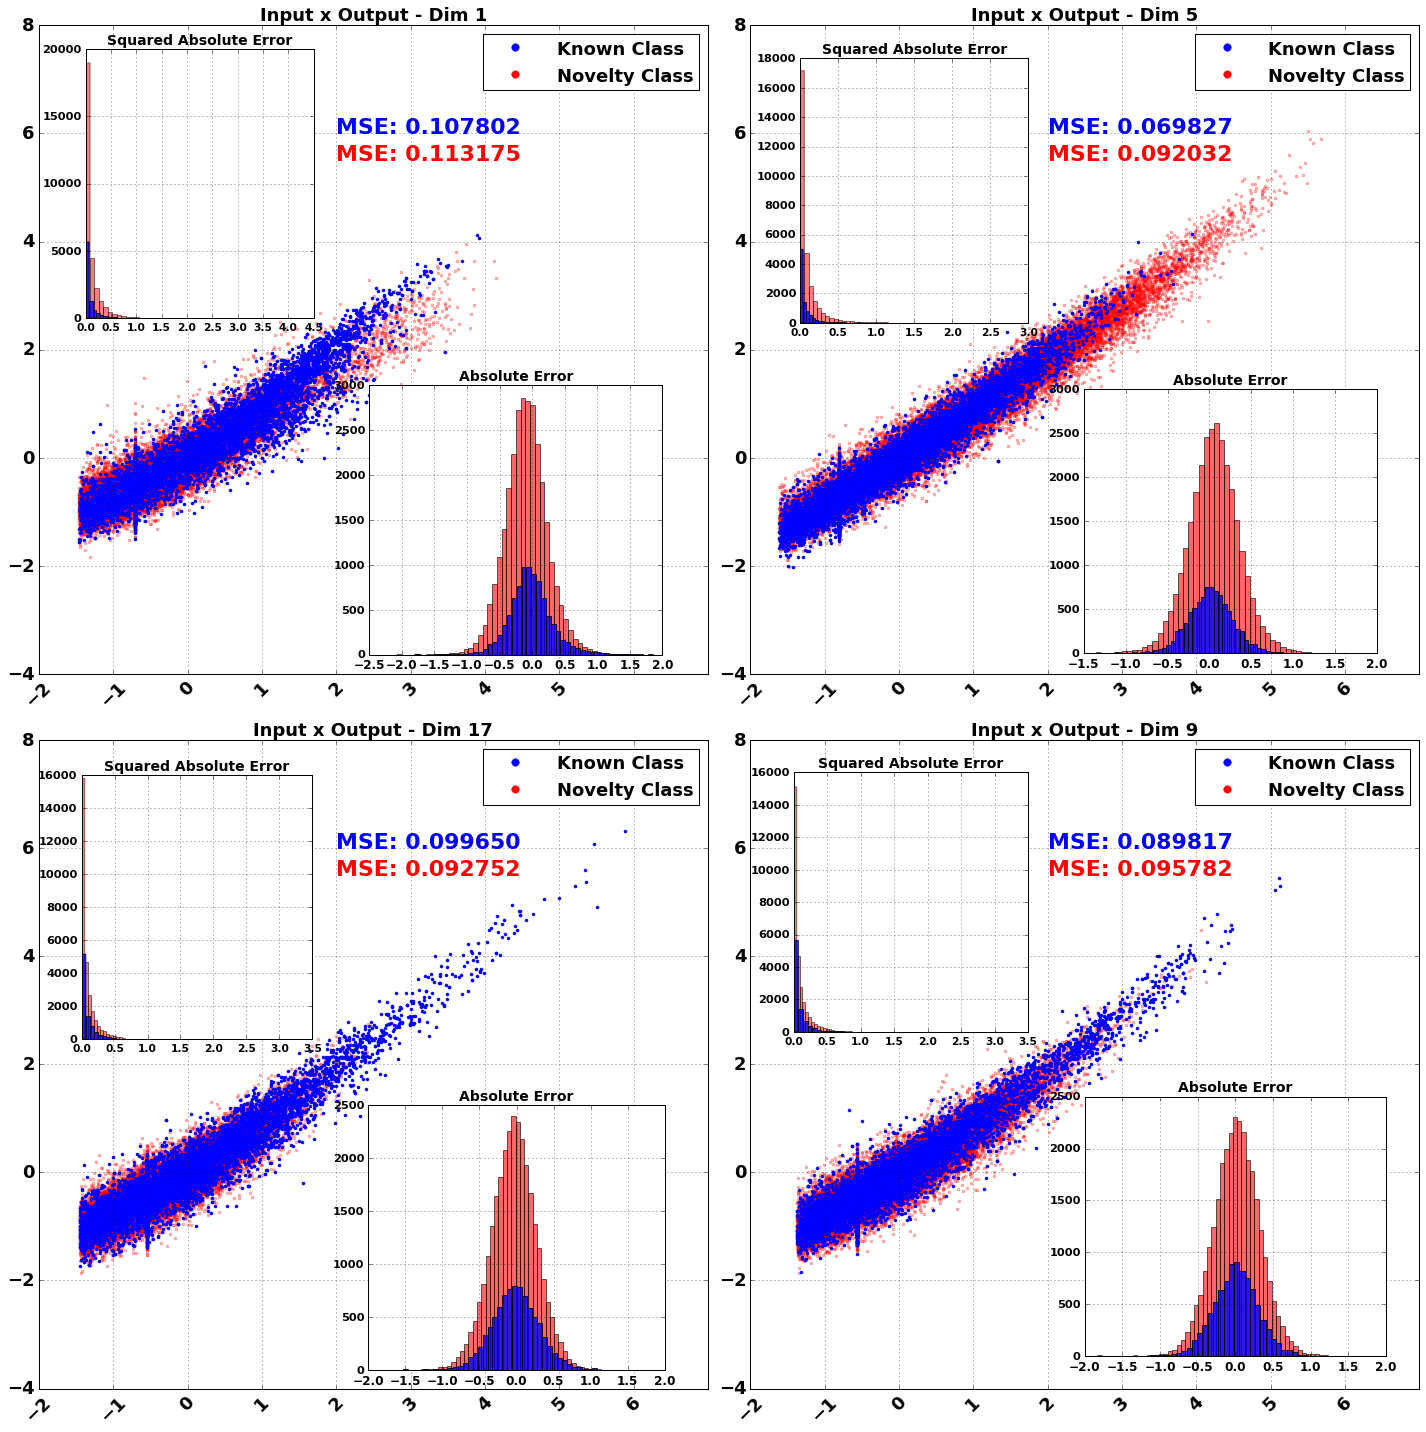

In [18]:
# Reconstruction of Known Classes vs Reconstruction of Novelty - novelty detection for neural network
%matplotlib inline 

# generate analysis data
save_path=results_path

current_analysis = 'reconstruction_known_x_novelty'
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

# Choose model
inovelty = 1
regularizer = ""
regularizer_param = 0.5

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

params_str = trn_params.get_params_str()

neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer])

models = {}
known_outputs = {}
novelty_outputs = {}
mean = {}
indexes = {}

n_folds = len(CVO[inovelty])

for ifold in range(n_folds):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
    norm_data = scaler.transform(all_data)
    known_data = scaler.transform(known_data[test_id,:])
    novelty_data = scaler.transform(all_data[all_trgt==inovelty])
    
    if ifold == 0:
        diffSquared = np.zeros([len(CVO[inovelty]), all_data.shape[0], all_data.shape[1]])
        
    print 'Novelty class: %i - Topology: %s - fold %i'%(inovelty, neurons_str, ifold)
    
    ifold, models[ifold], trn_desc = SAE[inovelty].trainLayer(data = trn_data[inovelty],
                                                              trgt = trn_trgt[inovelty],
                                                              ifold = ifold,
                                                              hidden_neurons = hidden_neurons,
                                                              layer = layer,
                                                              regularizer = regularizer,
                                                              regularizer_param = regularizer_param)
    
    outputs = models[ifold].predict(norm_data)
    known_outputs[ifold] = models[ifold].predict(known_data)
    novelty_outputs[ifold] = models[ifold].predict(novelty_data)
    
    diffSquared[ifold] = np.power((norm_data - outputs), 2)
      
mean = np.mean(np.mean(diffSquared[:,test_id,:], axis=0), axis=0)
indexes = np.argsort(mean)[::-1]
print "Topology (%s)"%trn_params.get_params_str()
for ifold in range(len(CVO[inovelty])):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
    norm_data = scaler.transform(all_data)
    known_data = scaler.transform(known_data[test_id,:])
    novelty_data = scaler.transform(all_data[all_trgt==inovelty])
    
    known_points = known_data.shape[0]
    novelty_points = novelty_data.shape[0]
    
    # Number of dimensions to analyse (even number is better!)
    num_dim = 4
    fig, m_ax = plt.subplots(figsize=(20,20),nrows=2, ncols=2)
    for choose_index in range(num_dim):  
        ax = plt.subplot(2,2,choose_index+1)
        
        # Plot novelty 
        ax.plot(novelty_data[:,indexes[choose_index]][0], 
                novelty_outputs[ifold][:,indexes[choose_index]][0],
                "r.", label='Novelty Class', markersize=15)
        ax.plot(novelty_data[:,indexes[choose_index]][:novelty_points], 
                novelty_outputs[ifold][:,indexes[choose_index]][:novelty_points],
                "r.", alpha=0.3)
        
        # Plot known classes
        ax.plot(known_data[:,indexes[choose_index]][0],
                known_outputs[ifold][:,indexes[choose_index]][0],
                "b.", label='Known Class', markersize=15)
        ax.plot(known_data[:,indexes[choose_index]][:known_points],
                known_outputs[ifold][:,indexes[choose_index]][:known_points],
                "b.")
        
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title('Input x Output - Dim %i'%(indexes[choose_index]),fontsize=18, fontweight='bold')
        ax.set_xlim(-2, 7)
        ax.set_ylim(-4, 8)
        handles, labels = ax.get_legend_handles_labels()
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        plt.grid() 
        
        # Small plot
        rect = [0.065, 0.55, 0.35, 0.4]
        ax1 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        eq_known_reconstruction = np.power((known_data[:,indexes[choose_index]] - known_outputs[ifold][:,indexes[choose_index]]), 2)
        eq_novelty_reconstruction = np.power((novelty_data[:,indexes[choose_index]] - novelty_outputs[ifold][:,indexes[choose_index]]), 2)
        
        mq_bins_known = np.linspace(np.min(eq_known_reconstruction), np.max(eq_known_reconstruction), 50)
        mq_bins_novelty = np.linspace(np.min(eq_novelty_reconstruction), np.max(eq_novelty_reconstruction), 50)
             
        n, bins, patches = ax1.hist(eq_novelty_reconstruction,bins=mq_bins_novelty,
                                    fc="r",
                                    alpha=0.5, normed=0)
        
        n, bins, patches = ax1.hist(eq_known_reconstruction,bins=mq_bins_known,
                                    fc="b",
                                    alpha=0.8, normed=0)   
#         ax1.set_xlim(0, 0.06)
        ax1.set_title("Squared Absolute Error",fontsize=14, fontweight='bold')
        ax1.grid() 
        
        # Small plot
        rect = [0.5, 0.05, 0.45, 0.4]
        ax2 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        e_known_reconstruction = (known_data[:,indexes[choose_index]] - known_outputs[ifold][:,indexes[choose_index]])
        e_novelty_reconstruction = (novelty_data[:,indexes[choose_index]] - novelty_outputs[ifold][:,indexes[choose_index]])
        
        m_bins_known = np.linspace(np.min(e_known_reconstruction), np.max(e_known_reconstruction), 50)
        m_bins_novelty = np.linspace(np.min(e_novelty_reconstruction), np.max(e_novelty_reconstruction), 50)
        
        n, bins, patches = ax2.hist(e_novelty_reconstruction,bins=m_bins_novelty,
                                    fc="r",
                                    alpha=0.6, normed=0)
        
        n, bins, patches = ax2.hist(e_known_reconstruction,bins=m_bins_known,
                                    fc="b",
                                    alpha=0.8, normed=0)   
        ax2.grid()
        ax2.set_title("Absolute Error",fontsize=14, fontweight='bold')
#         ax2.set_xlim(-0.4,0.4) 
        
        ax.legend(handles, labels, ncol=1, loc='upper right')
        plt.legend()

        mse = metrics.mean_squared_error(known_data[:,indexes[choose_index]], known_outputs[ifold][:,indexes[choose_index]])
        ax.text(2, 6, 'MSE: %f'%mse, style='normal',fontsize=22, color='blue',
        bbox={'alpha':0.0, 'pad':10})
        
        mse = metrics.mean_squared_error(novelty_data[:,indexes[choose_index]], novelty_outputs[ifold][:,indexes[choose_index]])
        ax.text(2, 5.5, 'MSE: %f'%mse, style='normal',fontsize=22, color='red',
        bbox={'alpha':0.0, 'pad':10})
        
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%i_novelty_%i_layer_%s_neurons_%i_fold_'%(inovelty,
                                                                                                       layer,
                                                                                                       neurons_str,
                                                                                                       ifold)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)
    plt.show()

In [ ]:
projection = SAE[inovelty].getDataProjection(data = all_data, trgt=all_trgt, ifold = 0,
                                             hidden_neurons = hidden_neurons, layer = layer)
print projection.shape


# Treinamento de Classificação

In [ ]:
# Train classifiers to their corresponding folds
def trainClassifierFold(ifold): 
    return SAE[inovelty].trainClassifier(data=all_data,
                        trgt = all_trgt,
                        ifold = 0,
                        hidden_neurons=hidden_neurons,
                        layer = 3)

# Train classifier sweeping the number of layer
def trainClassifierLayer(ilayer):
    for ifold in range(len(CVO)):
        SAE.trainClassifier(data=all_data,
                            trgt = all_trgt,
                            ifold = ifold,
                            hidden_neurons=hidden_neurons,
                            layer = ilayer)
start_time = time.time()

p = multiprocessing.Pool(num_processes)

folds = range(len(CVO))
results = p.map(trainClassifierFold, folds)

# layers = range(1,11)
# results = p.map(trainClassifierLayer, layers)

p.close()
p.join()

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

In [ ]:
classifier = SAE.loadClassifier(data = all_data, trgt = all_trgt, hidden_neurons=hidden_neurons, layer=3, ifold = 0)

In [ ]:
train_id, test_id = CVO[0]
output = classifier.predict(all_data[test_id, :])
print sklearn.metrics.classification_report(trgt_sparse[test_id], np.round(output), target_names=class_labels.values())